/home/artemy/virtenv/proj_env/lib/python3.8/site-packages/pyproj/crs/crs.py:543: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj_string = self.to_proj4()


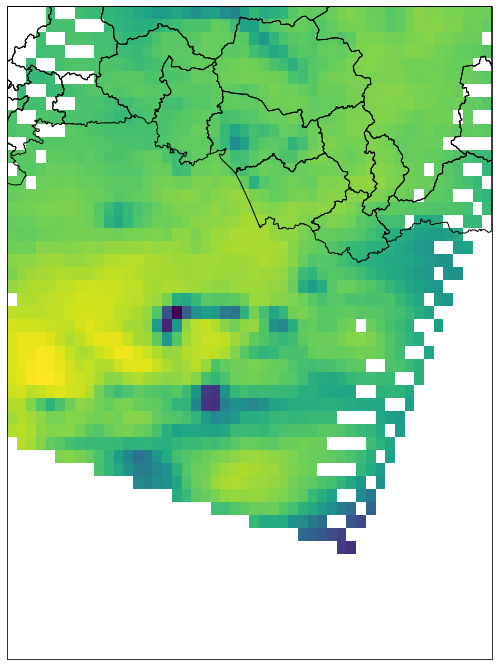

In [5]:
import h5py
import numpy as np
from pyhdf.SD import SD,SDC
import matplotlib.pyplot as plt
from pyresample.kd_tree import resample_nearest
from pyresample.geometry import AreaDefinition, SwathDefinition
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader
import cartopy.feature as cfeat

reader=shpreader.Reader("rus_borders/RUS_adm1.shp")
counties=list(reader.geometries())
coun=cfeat.ShapelyFeature(counties,ccrs.PlateCarree())

atms_file="data/GATMO-SATMS_npp_d20150714_t2058223_e2106219_b19231_c20200718094932477386_noaa_ops.h5"
amsu_file="data/AIRS.2015.07.14.208.L1B.AMSU_Rad.v5.0.0.0.G15196140249.hdf"

with h5py.File(atms_file, "r") as h5data:
    lon_at=h5data["All_Data/ATMS-SDR-GEO_All/Longitude"][:]
    lat_at=h5data["All_Data/ATMS-SDR-GEO_All/Latitude"][:]
    bt_at=h5data["All_Data/ATMS-SDR_All/BrightnessTemperature"][:]
    bt_factors_at=h5data["All_Data/ATMS-SDR_All/BrightnessTemperatureFactors"][:]

hdf=SD(amsu_file, SDC.READ)

lon_am=hdf.select("Longitude")[:]
lat_am=hdf.select("Latitude")[:]
bt_am=hdf.select("brightness_temp")[:]

bt_at=bt_at*bt_factors_at[0]+bt_factors_at[1]

#ch_1=bt_am[:,:,14]
ch_1=bt_at[:,:,0]

area_id="altai_laea"
description="Altai Lambert Azimuthal Equal Area grid"
proj_id="altai_laea"
projection={"proj": "laea", "lat_0": 52.5, "lon_0": 83.5, "ellps": "WGS84"}
width=50
height=50
area_extent=(-1600000.0, -2500000.0, 1000000.0, 1000000.0)

swath_def=SwathDefinition(lons=lon_at, lats=lat_at)

area_def=AreaDefinition(area_id, description, proj_id, projection,
                        width, height, area_extent)
result=resample_nearest(swath_def, ch_1, area_def, 
                        radius_of_influence=20000, fill_value=None)

crs=area_def.to_cartopy_crs()
#fig, ax=plt.subplots(subplot_kw=dict(projection=crs))
fig=plt.figure(1, figsize=(14,12))
ax=plt.subplot(111, projection=crs)
ax.add_feature(coun,facecolor="none",edgecolor="black")
img=plt.imshow(result, transform=crs, extent=crs.bounds, origin="upper")
fig.savefig("atms_bt.png", bbox_inches='tight')